In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding


from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection
import tensorflow as tf
import numpy as np

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

In [4]:
dataset = datasets.CiteSeer()
display(HTML(dataset.description))
G, _ = dataset.load()

In [5]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 3312, Edges: 4715

 Node types:
  paper: [3312]
    Features: float32 vector, length 3703
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [4715]
        Weights: all 1 (default)


In [6]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 471 positive and 471 negative edges. **


In [7]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 424 positive and 424 negative edges. **


In [8]:
epochs = 40

In [9]:
train_gen = FullBatchLinkGenerator(G_train, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

Using GCN (local pooling) filters...


In [10]:
test_gen = FullBatchLinkGenerator(G_test, method="gcn")
test_flow = train_gen.flow(edge_ids_test, edge_labels_test)

Using GCN (local pooling) filters...


In [11]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3
)

In [12]:
x_inp, x_out = gcn.in_out_tensors()

In [13]:
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

In [14]:
prediction = keras.layers.Reshape((-1,))(prediction)

In [15]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=0.01),
    loss=keras.losses.binary_crossentropy,
    metrics=["binary_accuracy"],
)

In [16]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 3ms/step - loss: 1.9132 - binary_accuracy: 0.5000

Train Set Metrics of the initial (untrained) model:
	loss: 1.8784
	binary_accuracy: 0.5000

Test Set Metrics of the initial (untrained) model:
	loss: 1.9132
	binary_accuracy: 0.5000


In [17]:
history = model.fit(
    train_flow, epochs=epochs, validation_data=test_flow, verbose=2, shuffle=False
)

Epoch 1/40
1/1 - 0s - loss: 1.7267 - binary_accuracy: 0.5012 - val_loss: 7.1590 - val_binary_accuracy: 0.5011
Epoch 2/40
1/1 - 0s - loss: 6.7182 - binary_accuracy: 0.5012 - val_loss: 7.4773 - val_binary_accuracy: 0.5000
Epoch 3/40
1/1 - 0s - loss: 7.2777 - binary_accuracy: 0.4988 - val_loss: 7.2668 - val_binary_accuracy: 0.5000
Epoch 4/40
1/1 - 0s - loss: 6.7225 - binary_accuracy: 0.5071 - val_loss: 5.0698 - val_binary_accuracy: 0.5265
Epoch 5/40
1/1 - 0s - loss: 4.6759 - binary_accuracy: 0.5601 - val_loss: 1.0353 - val_binary_accuracy: 0.6964
Epoch 6/40
1/1 - 0s - loss: 1.0444 - binary_accuracy: 0.7771 - val_loss: 0.5898 - val_binary_accuracy: 0.7113
Epoch 7/40
1/1 - 0s - loss: 0.4307 - binary_accuracy: 0.7771 - val_loss: 0.8293 - val_binary_accuracy: 0.5902
Epoch 8/40
1/1 - 0s - loss: 0.6732 - binary_accuracy: 0.6439 - val_loss: 0.8740 - val_binary_accuracy: 0.5796
Epoch 9/40
1/1 - 0s - loss: 0.7674 - binary_accuracy: 0.5861 - val_loss: 0.7560 - val_binary_accuracy: 0.6125
Epoch 10/4

Plot the training history:

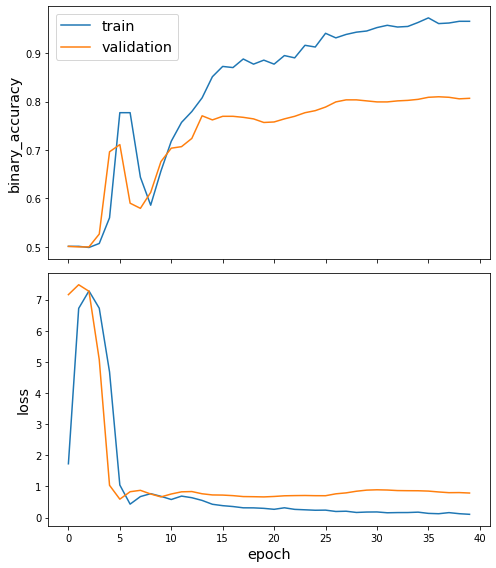

In [18]:
sg.utils.plot_history(history)

Evaluate the trained model on test citation links:

In [19]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 2ms/step - loss: 0.7873 - binary_accuracy: 0.8068

Train Set Metrics of the trained model:
	loss: 0.0679
	binary_accuracy: 0.9894

Test Set Metrics of the trained model:
	loss: 0.7873
	binary_accuracy: 0.8068
